# **Assignment 2** - Unsupervised learning
Group 21 - Endre Wasbø, Soraj Singh, Håkon Årdal

## Framing the Problem


Industrial robotic arms often require extremely high precision to complete their tasks accurately and efficiently. Any deviation from expected performance can lead to defects, increased downtime, or even damage to equipment. Therefore, implementing real-time anomaly detection is crucial for ensuring smooth and reliable operation.  

The primary business objective of real-time anomaly detection is to identify irregularities during operation before they escalate into critical failures. By continuously monitoring sensor data, the system can detect deviations from normal patterns. This allows for immediate corrective action, such as halting the process or triggering automated adjustments.  

By preventing potential failures early, businesses can reduce waste, minimize downtime, and maintain high-quality production standards. Additionally, proactive anomaly detection enhances equipment longevity, reduces maintenance costs, and improves overall operational efficiency.



---
We will explore three different methods for anomaly detection: K-Means, Isolation Forrest and Gaussian Mixture.

Performance should be measured by validating the model on nomal data found in ``IMU_20Hz_freq_drop.csv`` and  `IMU_10Hz`. A suitable threshold will be chosen to detect unnormal behaviour over a time window.

* For K-Means we will compare the inertias of the clusters to the inertias generated from normal data.

* For Isolation Forrest, anomalies are determined by their path leghts (explained later). The anomaly fraction will then be used as a metric for the time series. Due to the nature of how the model detects anomalies, we will visually compare sensor data to validate its responsiveness and accuracy.

* For Gaussian Mixture we will use BIC and AIC scores to select the number of components/clusters. The metrics indicates how well the model fits the data, while penalizing complxity. We will use the mean log-likelihood to determine anomlies. 



### Assumptions

* Due to how the IMU is set up for data collection, we assume some variations in data quality. The IMU is placed on a breadboard that is secured with a strap, meaning it is likely prone to small orienational variations between each recording. As we will see later, this could explain the minor deviations found in the normal data recorded from ``IMU_20Hz_freq_drop.csv``. To account for this, we will simply adjust the threshold (defining anomalies) accordingly.

* After testing with resampling techniques to maintain a consistent sampling frequency, without any significant differences, we assume that the sampling frequency of the different IMUs does not impose any difference.

# Collecting the Data

For anomaly detection to work, we need a sequential repetitive process. The model will then generate clusters based on normal data. 
Our chosen dataset is extracted form an industrial robot arm that sequentially performs three distinct tasks: screwdriving, painting, and pick-and-place.
The dataset is collected by Hakan Kayan and is found here:
https://www.kaggle.com/datasets/hkayan/industrial-robotic-arm-imu-data-casper-1-and-2?fbclid=IwY2xjawI3yJdleHRuA2FlbQIxMAABHeB7cl5kMDV8YOgyqVeK-oP1pkBnbs1WEpvr3ZeDjBVKGANccmx1C2IKeg_aem_ZMw13qbiYzDAL9aYGz2JHA

The dataset files contain IMU data at different sampling rates and configurations, including acceleration, gyroscope, and quaternion data. For this task, we will limit our scope to using only the accelerations, gyroscope and magnetometer without making complex estimations of the states.

The dataset includes data from five simulated anomalies: earthquake vibration, collision with the arm, platform impact, extra weight on the gripper, and unexpected magnetic fields. We will use these to test how well our models is capable of detecting anomalies.

# Setup

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Imports and Functions

In [60]:
import seaborn as sns
import pandas as pd
from scipy.stats import skew, kurtosis, gaussian_kde
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import matplotlib.cm as cm
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import pairwise_distances
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.preprocessing import StandardScaler

def get_data_frame(filename):
    CSV_FOLDER_NAME = "Robotic Arm"
    csv_filepath = os.path.join(CSV_FOLDER_NAME, filename)
    return pd.read_csv(csv_filepath)

def plot_corr_matrix(data):
    corr = data.corr()
    plt.figure(figsize=(12, 7))
    sns.heatmap(corr, annot=True,mask=np.triu(corr), cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show() 

def add_time_column(df):
    df['time'] = pd.to_datetime(df['time'], unit='ns')
    df.set_index('time', inplace=True)
    return df

def extract_rolling_features(df):
    sensor_cols = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'magX', 'magY', 'magZ']

    # Use a rolling window of 1 second and extraxt key features
    features_df = df[sensor_cols].rolling(window='1S').agg(['mean', 'std'])

    # Flatten MultiIndex
    features_df.columns = ['_'.join(col).strip() for col in features_df.columns]
    
    # Remove nan (to be sure)
    features_df = features_df.dropna().reset_index(drop=True)
    
    return features_df

def resample_to_10Hz(df):
    # Behold kun numeriske kolonner for resampling
    df_numeric = df.select_dtypes(include=[np.number])

    # Resample til target frequency (10Hz = 100ms)
    df_resampled = df_numeric.resample("100ms").mean().dropna()
    return df_resampled


def plot_bic_aic(X_scaled, n_components_range, sample_size=10000):

    # Sample from X_scaled to increase performance
    if len(X_scaled) > sample_size:
        np.random.seed(21) 
        indices = np.random.choice(len(X_scaled), size=sample_size, replace=False)
        X_sampled = X_scaled[indices]
    else:
        X_sampled = X_scaled

    # Store metrics
    bic_values = []
    aic_values = []
    
    for n in n_components_range:
        gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=21)
        gmm.fit(X_sampled)
        
        bic_values.append(gmm.bic(X_sampled))
        aic_values.append(gmm.aic(X_sampled))
        # print(f"n={n}: BIC={bic_values[-1]:.2f}, AIC={aic_values[-1]:.2f}")

    # Plotter BIC og AIC
    plt.figure(figsize=(8, 5))
    plt.plot(n_components_range, bic_values, label='BIC', marker='o')
    plt.plot(n_components_range, aic_values, label='AIC', marker='s')
    plt.xlabel('Number of components')
    plt.ylabel('Score')
    plt.title('BIC and AIC for GMM')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_anomalies_histogram(filename, threshold, gmm, scaler, x_start=-500, x_end=50, resample_10Hz=False):
    # Get the data from csv
    df = get_data_frame(filename)

    # Add pandas time
    df = add_time_column(df)

    if resample_10Hz:
        # Resample to 10Hz to keep consistency
        df = resample_to_10Hz(df)

    # Extract rolling features
    X_data = extract_rolling_features(df)

    # Scale the data using the existing scaler
    X_data_scaled = scaler.transform(X_data)

    # Calculate log-likelihood and anomalies
    log_likelihood = gmm.score_samples(X_data_scaled)

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(log_likelihood, bins=100, color='gray', alpha=0.7, label="Log-Likelihood", edgecolor='black', density=True)

    # KDE (Kernel Density Estimate) for the distribution
    kde = gaussian_kde(log_likelihood, bw_method='silverman')
    x_range = np.linspace(min(log_likelihood), max(log_likelihood), 1000)
    kde_values = kde(x_range)

    # Shaded region under the KDE curve
    plt.fill_between(x_range, kde_values, color='blue', alpha=0.2, label="Density")

    # Add a vertical line for anomaly threshold
    plt.axvline(threshold, color='coral', linestyle='dashed', linewidth=3, label="0.5 % Likelihood")

    # Add a vertical line for mean Log-Likelihood
    plt.axvline(log_likelihood.mean(), color='blue', linestyle='-', linewidth=2, label="Mean Log-Likelihood")

    # Add labels and title
    plt.xlabel('Log-Likelihood')
    plt.ylabel('Density')
    plt.title('Histogram of Log-Likelihood with Anomalies and KDE Distribution. ' + filename)
    plt.legend()

    plt.xlim(x_start, x_end)

    # Show plot
    plt.show()

def plot_log_likelihood_timeseries(filename, threshold, gmm, scaler, resample_10Hz=True):
    # Get the data from csv
    df = get_data_frame(filename)

    # Add pandas time
    df = add_time_column(df)

    if resample_10Hz:
        # Resample to 10 Hz
        df = resample_to_10Hz(df)

    # Extract rolling features
    X_data = extract_rolling_features(df)

    # Scalse the data
    X_data_scaled = scaler.transform(X_data)

    # Calculate log-likelihood and anomalies globally
    log_likelihood = gmm.score_samples(X_data_scaled)
    anomalies = log_likelihood < threshold

    # Get time values
    time_values = df.index  

    # Interactive widgets
    start_slider = widgets.IntSlider(value=0, min=0, max=len(time_values)-100, step=10, description='Start:')
    window_slider = widgets.IntSlider(value=500, min=100, max=5000, step=100, description='Window:')

    def update_plot(start, window):
        # Define plot end
        end = min(start + window, len(time_values))

        # Anomaly fraction of current time window
        log_likelihood_mean = log_likelihood[start:end].mean()

        # Update new plot
        plt.figure(figsize=(12, 6))
        plt.plot(time_values[start:end], log_likelihood[start:end], label="Log-Likelihood", color="gray")
        # plt.scatter(time_values[start:end][anomalies[start:end]], 
        #             log_likelihood[start:end][anomalies[start:end]], 
        #             color='black', label="Anomalies", zorder=3, s=3)
        
        plt.axhline(threshold, color='coral', linestyle='dashed', linewidth=3, label="0.5 % Likelihood")

        plt.axhline(log_likelihood_mean, color='blue', linestyle='-', linewidth=2, label="Mean Log-Likelihood (current window)")


        # Display current anomaly fraction
        text_str = f"Mean Log-Likelihood (current window): {log_likelihood_mean:.2f}"
        plt.text(0.02, 0.05, text_str, transform=plt.gca().transAxes, 
                 fontsize=12, verticalalignment='top', 
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

        plt.xlabel("Time")
        plt.ylabel("Log-Likelihood")
        plt.title("Log-Likelihood Timeseries " + filename)
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

    # Make interactive plot
    interactive_plot = widgets.interactive(update_plot, start=start_slider, window=window_slider)
    display(interactive_plot)


def plot_silhouette(X_normal, scaler):

    # Define range of k values to test
    K_range = [6, 8, 10, 12]  

    # Sample a subset of the data for faster computation
    sample_size = min(10000, len(X_normal))  # Use max 10,000 samples
    X_sampled = X_normal.sample(n=sample_size, random_state=21)
    X_scaled = scaler.fit_transform(X_sampled)

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))  
    axes = axes.flatten()  

    for idx, k in enumerate(K_range):
        print(f"Processing k={k}...")

        # Apply MiniBatchKMeans with reduced batch size
        kmeans = MiniBatchKMeans(n_clusters=k, batch_size=256, random_state=21)
        labels = kmeans.fit_predict(X_scaled)

        # Compute silhouette score
        silhouette_avg = silhouette_score(X_scaled, labels)

        # Skip if silhouette score is too low (bad clustering)
        if silhouette_avg < 0.1:
            print(f"Skipping k={k} due to low silhouette score ({silhouette_avg:.2f})")
            continue  

        # Compute silhouette samples
        sample_silhouette_values = silhouette_samples(X_scaled, labels)

        # Create silhouette plot
        ax = axes[idx]
        y_lower = 10
        for i in range(k):
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.Blues(float(i) / k)
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10  

        ax.set_title(f'k = {k}')
        ax.set_xlabel("Silhouette Coefficient")
        ax.set_ylabel("Cluster")
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")  
        ax.set_xlim([-0.1, 1])  
        ax.set_ylim([0, sample_size])  

    plt.suptitle("Optimized Silhouette Analysis for Different k values")
    plt.tight_layout()
    plt.show()


def plot_kmeans_inertias(normal_inertia_per_cluster, kmeans, scaler, filename, is_test_data=False):

    
    if not is_test_data:
        # Load data
        df = get_data_frame(filename)
        df = add_time_column(df)
    else:
        df = filename

    df_resampled = resample_to_10Hz(df)
    X_data = extract_rolling_features(df_resampled)

    # Drop NaN values
    X_data = X_data.dropna().reset_index(drop=True)
    
    # Scale the data
    X_data_scaled = scaler.transform(X_data)

    # Predict cluster labels
    anomaly_labels = kmeans.predict(X_data_scaled)

    # Compute per-cluster normalized inertia
    anomaly_inertia_per_cluster = np.zeros(kmeans.n_clusters)
    for i in range(kmeans.n_clusters):
        cluster_points = X_data_scaled[anomaly_labels == i]
        if len(cluster_points) > 0:  # Avoid division by zero
            anomaly_inertia_per_cluster[i] = np.sum((cluster_points - kmeans.cluster_centers_[i])**2) / len(cluster_points)

    # Plot results
    clusters = np.arange(kmeans.n_clusters)

    bar_color = (0.0, 0.2, 0.50)  # Soft blue for bars
    line_color = sns.color_palette("Reds", as_cmap=True)(0.7)  # Soft red for lines

    plt.figure(figsize=(10, 6))
    plt.bar(clusters, anomaly_inertia_per_cluster, color=bar_color, alpha=0.6, label="Anomaly Data Inertia")

    bar_width = 0.6  # Adjust based on your bar width
    # Plot horizontal red lines for each cluster at its corresponding normal inertia value
    for i, normal_value in enumerate(normal_inertia_per_cluster):
        plt.hlines(y=normal_value, xmin=i - 0.5, xmax=i + 0.5, colors=line_color, linestyles="-", linewidth=2.5)

    plt.xlabel("Cluster")
    plt.ylabel("Normalized Inertia")
    plt.title("Cluster-Wise Normalized Inertia (Test vs. Normal)")
    plt.legend()
    plt.show()
    
    return anomaly_inertia_per_cluster


def iso_anomaly_detection(filename, model):
    df = get_data_frame(filename)
    df = add_time_column(df)

    X_normal_iso = extract_rolling_features(df)
    scaler = StandardScaler()
    X_normal_scaled_iso = scaler.fit_transform(X_normal_iso)

    iso_df = df.copy()
    iso_df = iso_df.iloc[:-1]

    iso_df['anomaly_score'] = model.decision_function(X_normal_scaled_iso)
    iso_df['anomaly'] = model.predict(X_normal_scaled_iso)

    return iso_df

def anomaly_fraction(df):
    num_anomalies = (df['anomaly'] == -1).sum()
    total_points = len(df)
    return num_anomalies / total_points *100

def plot_anomaly_frac(filenames, anomaly_lst):
    """Visualiser anomaliprosentene for flere tester ved hjelp av et søylediagram."""

    # Plot resultatene
    plt.figure(figsize=(10, 6))
    plt.bar(filenames, anomaly_lst, color='skyblue')
    plt.xlabel('Timeseries')
    plt.ylabel('Percentage anomalies')
    plt.title('Percentage anomalies per test')
    plt.ylim(0, 100)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_sensor_data_with_anomalies(df, sensor_cols, start_time=None, end_time=None, num_points=1000, name=""):

    filtered_df = df[(df.index.strftime("%H:%M:%S") >= start_time) & (df.index.strftime("%H:%M:%S") <= end_time)]

    if num_points and len(filtered_df) > num_points:
        filtered_df = filtered_df.sample(n=num_points, random_state=42).sort_index()

    filtered_df['is_anomaly'] = filtered_df['anomaly'] == -1  

    
    fig, axes = plt.subplots(len(sensor_cols), 1, figsize=(10, len(sensor_cols) * 3), sharex=True)

    if len(sensor_cols) == 1:
        axes = [axes] 

    for i, sensor in enumerate(sensor_cols):
        ax = axes[i]
        ax.plot(filtered_df.index, filtered_df[sensor], label=sensor, color='blue')

        
        anomalies = filtered_df[filtered_df['is_anomaly']]
        if not anomalies.empty:
            ax.scatter(anomalies.index, anomalies[sensor], color='red', label='Anomalies', zorder=5)

        ax.set_title(f"{sensor} over time " + name)
        ax.set_ylabel(sensor)
        ax.legend()

    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()

def plot_sensor_data_with_anomalies(df, sensor_cols, start_time=None, end_time=None, num_points=1000, name=""):
    filtered_df = df[(df.index.strftime("%H:%M:%S") >= start_time) & (df.index.strftime("%H:%M:%S") <= end_time)].copy()

    if num_points and len(filtered_df) > num_points:
        filtered_df = filtered_df.sample(n=num_points, random_state=42).sort_index()

    filtered_df['is_anomaly'] = filtered_df['anomaly'] == -1  

    fig, axes = plt.subplots(len(sensor_cols), 1, figsize=(10, len(sensor_cols) * 3), sharex=True)

    if len(sensor_cols) == 1:
        axes = [axes] 

    for i, sensor in enumerate(sensor_cols):
        ax = axes[i]
        ax.plot(filtered_df.index, filtered_df[sensor], label=sensor, color='blue')

        anomalies = filtered_df[filtered_df['is_anomaly']]
        if not anomalies.empty:
            ax.scatter(anomalies.index, anomalies[sensor], color='red', label='Anomalies', zorder=5)

        ax.set_title(f"{sensor} over time " + name)
        ax.set_ylabel(sensor)
        ax.legend()

    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()


import time
from collections import deque

class OnlineAnomalyDetector:
    def __init__(self, model, scaler, window_size=15):
        self.model = model
        self.scaler = scaler
        self.window_size = window_size
        self.window = deque(maxlen=window_size)

    def preprocess(self, new_data):

        self.window.append(new_data)

        if len(self.window) < self.window_size:
            return None

        cols = ["accX", "accY", "accZ", "gyroX", "gyroY", "gyroZ", "magX", "magY", "magZ"]
        window_df = pd.DataFrame(self.window, columns=cols)

        rolling_features = window_df.rolling(window=self.window_size, min_periods=1).agg(['mean', 'std'])

        rolling_features.columns = ['_'.join(col).strip() for col in rolling_features.columns]

        rolling_features = rolling_features.dropna()

        X_scaled = self.scaler.transform(rolling_features)

        return X_scaled[-1:] 

    def predict(self, new_data):

        X_scaled = self.preprocess(new_data)
        if X_scaled is None:
            return None, None 

        anomaly_score = self.model.decision_function(X_scaled)[0]
        prediction = self.model.predict(X_scaled)[0]
        anomaly = prediction == -1 

        return anomaly_score, anomaly
    
def stream_data(filename, detector, delay=0.0, doPrint=False, max_length=1000):

    df = get_data_frame(filename)
    df = df.sort_index()
    
    sensor_cols = ["accX", "accY", "accZ", "gyroX", "gyroY", "gyroZ", "magX", "magY", "magZ"]
    
    anomaly_count = 0
    normal_count = 0
    total_count = 0
    data_points_processed = 0
    anomaly_scores = []
    anomaly_indexes = []

    print("\n🔍 Starter online anomaly detection...\n")

    df['anomaly_score'] = None
    df['anomaly'] = None

    for i, row in df.iterrows():
        if data_points_processed >= max_length:
            break
        
        data_point = row[sensor_cols].values.tolist()
        anomaly_score, anomaly = detector.predict(data_point)

        if anomaly is not None:
            total_count += 1
            anomaly_scores.append(anomaly_score)
            
            df.at[i, 'anomaly_score'] = anomaly_score
            df.at[i, 'anomaly'] = anomaly

            if anomaly:
                anomaly_count += 1
                anomaly_indexes.append(i)
            else:
                normal_count += 1
        
        data_points_processed += 1

        if doPrint:
            if anomaly is None:
                print(f"⏳ {i+1}: Venter på flere datapunkter...")
            elif anomaly:
                print(f"🚨 {i+1}: Anomaly detected!")
            else:
                print(f"✅ {i+1}: Normal data")

            time.sleep(delay)

    if total_count > 0:
        anomaly_percentage = (anomaly_count / total_count) * 100
        print(f"\n🔎 Totalt: {total_count} datapunkter.")
        print(f"🚨 Anomalier: {anomaly_count} ({anomaly_percentage:.2f}%)")
        print(f"✅ Normale datapunkter: {normal_count} ({100 - anomaly_percentage:.2f}%)")
    else:
        print("❌ Ingen data tilgjengelig for analyse.")
    
    return df


# Explore the Data

We start by exploriing the data from normal operation (``IMU_10Hz.csv``) 

In [5]:
raw_data = get_data_frame("IMU_10Hz.csv")
raw_data.head()

,name,time,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ
0,IMU8,1686062828391000000,9.773131,0.232238,0.490811,-0.1250,0.0000,0.0,0.000000,0.00,0.000000
1,IMU8,1686062828537000000,9.806650,0.263362,0.488417,0.0625,0.0000,0.0,-48.279999,-7.44,-13.230769
2,IMU8,1686062828585000000,9.794679,0.251391,0.442927,-0.1875,0.0000,0.0,-48.560001,-7.48,-13.230769
3,IMU8,1686062828682000000,9.770737,0.222661,0.445322,-0.0625,0.0625,0.0,-48.520000,-7.32,-13.461538
4,IMU8,1686062828780000000,9.792285,0.222661,0.464475,0.0000,0.0000,0.0,-48.360001,-7.28,-13.692307


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874937 entries, 0 to 874936
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   name    874937 non-null  object 
 1   time    874937 non-null  int64  
 2   accX    874937 non-null  float64
 3   accY    874937 non-null  float64
 4   accZ    874937 non-null  float64
 5   gyroX   874937 non-null  float64
 6   gyroY   874937 non-null  float64
 7   gyroZ   874937 non-null  float64
 8   magX    874937 non-null  float64
 9   magY    874937 non-null  float64
 10  magZ    874937 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 73.4+ MB


Looking at the object `name`, we see that it contains "IMUX", where X is a number, likely corresponding to the timeseries. We assume that the IMUs are identical and we can ignore this column.

In [7]:
# Look for missing data
missing_data = raw_data.isna().sum().sum()
print(f"Amount of missing data: {missing_data}") 

Amount of missing data: 0


### Feature scatter matrix plot

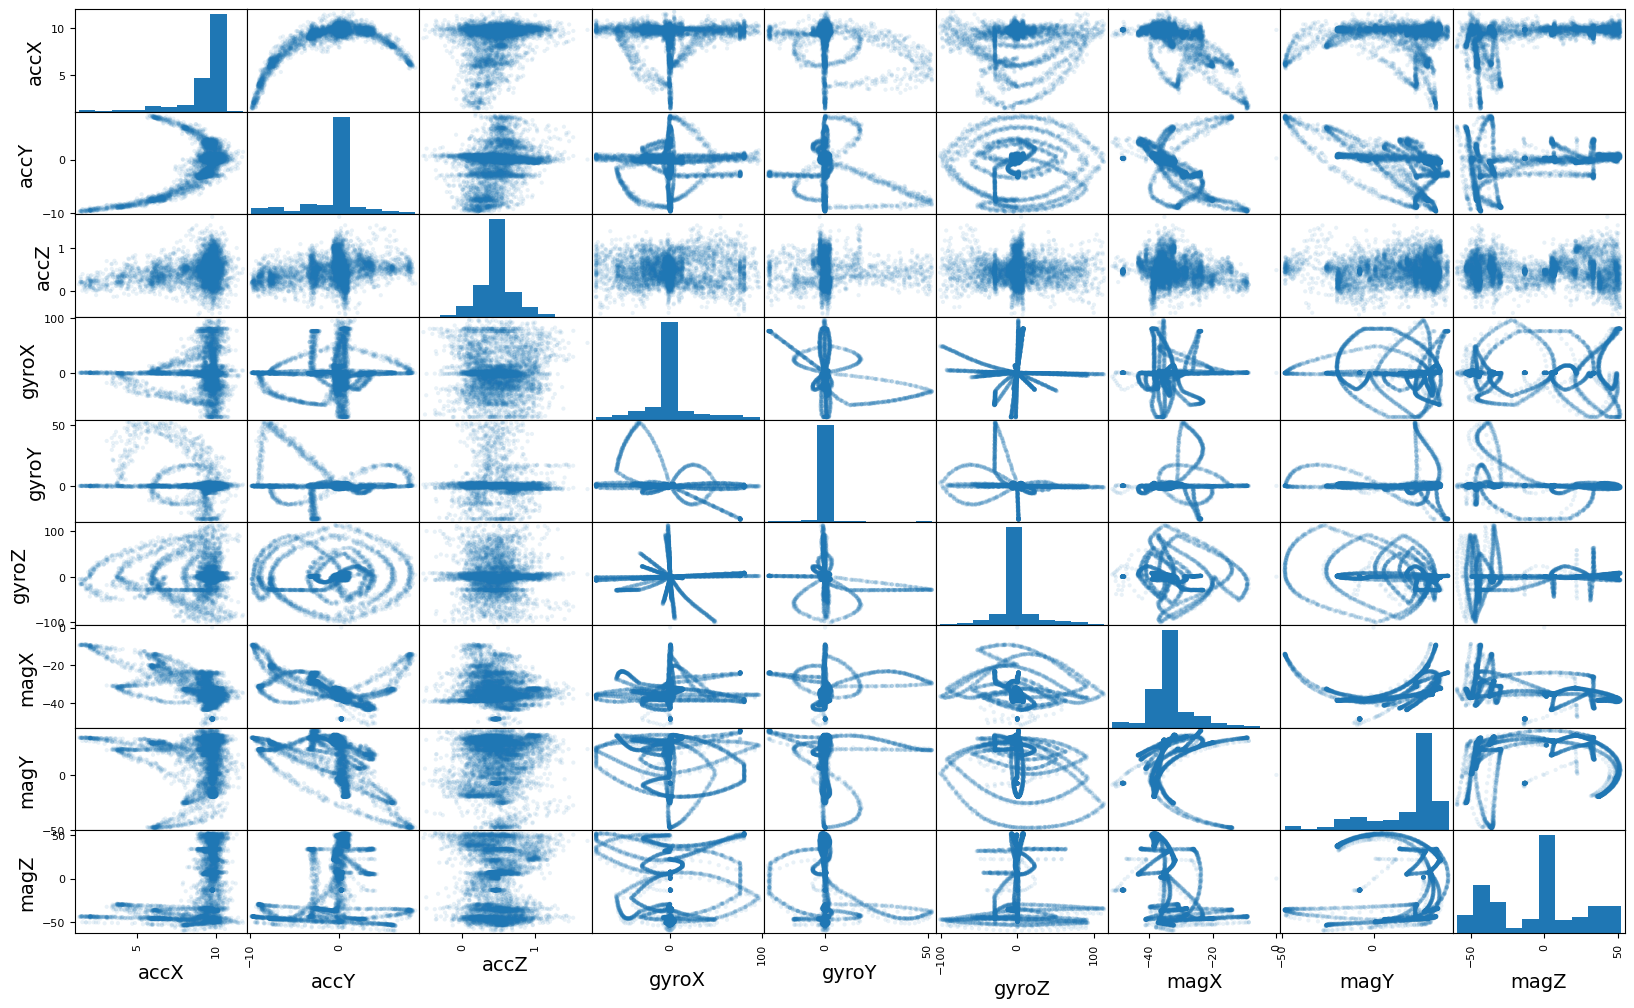

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(raw_data[:10000].drop(columns=['time']), figsize=(20, 12), alpha=0.1)

The scatter plot illustrates the continuous motion of the robotic arm, revealing intricate clusters. The complexity of the IMU data makes it highly suitable for a machine learning task.

# Prepare the Data

### Adding DateTime (Pandas functionality)
To add functionality to the timeseries we add a "DateTime" collumn. This allows ut to use processing functions such as ``.rolling()`` (as we will see later). 

In [8]:
raw_data = add_time_column(raw_data)
raw_data.head()

,name,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ
time,,,,,,,,,,
2023-06-06 14:47:08.391,IMU8,9.773131,0.232238,0.490811,-0.1250,0.0000,0.0,0.000000,0.00,0.000000
2023-06-06 14:47:08.537,IMU8,9.806650,0.263362,0.488417,0.0625,0.0000,0.0,-48.279999,-7.44,-13.230769
2023-06-06 14:47:08.585,IMU8,9.794679,0.251391,0.442927,-0.1875,0.0000,0.0,-48.560001,-7.48,-13.230769
2023-06-06 14:47:08.682,IMU8,9.770737,0.222661,0.445322,-0.0625,0.0625,0.0,-48.520000,-7.32,-13.461538
2023-06-06 14:47:08.780,IMU8,9.792285,0.222661,0.464475,0.0000,0.0000,0.0,-48.360001,-7.28,-13.692307


### Reduce the large training set
To make training faster, we will split the timeseries containing close to a million datapoints in half.

In [16]:
# Split normal data into test and train using a ratio to improve speed
ratio_train = 0.5

split_idx = int(len(raw_data) * ratio_train)

# Split the data
train_data = raw_data[:split_idx]
test_data = raw_data[split_idx:] 

print(f'Length train: {len(train_data)}')

Length train: 437468


Now, lets do some preprocessing of the data. Due to the varying sampling frequencies across the timeseries (as explained by the creator of the dataset), we initially chose to resample all new data to match the training frequency of 10 Hz. We later found that this made no significant difference to the results. ``resample_to_10Hz()`` is left as an option, but not necessary. The function ``extract_rolling_features()`` extracts the mean and the standard deviation from a rolling timewindow of 1 second. The reasoning for doing this is to smooth out sensor noise.

In [10]:
train_data_copy = train_data.copy()

# Resample to 10Hz
# train_data_copy = resample_to_10Hz(train_data_copy)

# Extract rolling features
X_normal = extract_rolling_features(train_data_copy)

X_normal.head()

,accX_mean,accX_std,accY_mean,accY_std,accZ_mean,accZ_std,gyroX_mean,gyroX_std,gyroY_mean,gyroY_std,gyroZ_mean,gyroZ_std,magX_mean,magX_std,magY_mean,magY_std,magZ_mean,magZ_std
0,9.789891,0.023701,0.247800,0.022008,0.489614,0.001693,-0.031250,0.132583,0.000000,0.000000,0.0,0.0,-24.139999,34.139115,-3.720000,5.260874,-6.615385,9.355567
1,9.791487,0.016986,0.248997,0.015700,0.474052,0.026981,-0.083333,0.130104,0.000000,0.000000,0.0,0.0,-32.280000,27.955651,-4.973333,4.307079,-8.820513,7.638788
2,9.786299,0.017320,0.242413,0.018377,0.466869,0.026300,-0.078125,0.106739,0.015625,0.031250,0.0,0.0,-36.340000,24.226982,-5.560000,3.707290,-9.980769,6.654735
3,9.787496,0.015237,0.238462,0.018202,0.466390,0.022802,-0.062500,0.098821,0.012500,0.027951,0.0,0.0,-38.744000,21.658857,-5.904000,3.301466,-10.723077,5.997435
4,9.787496,0.013628,0.239420,0.016449,0.472057,0.024669,-0.072917,0.091998,0.000000,0.039528,0.0,0.0,-40.320000,19.753165,-6.180000,3.029323,-11.269231,5.528570


# Scaling the Data
The data is scaled using `StandardScaler()`.

In [11]:
from sklearn.preprocessing import StandardScaler

# Create scaler
scaler = StandardScaler()
X_normal_scaled = scaler.fit_transform(X_normal)

# **K-Means**

K-Means is a clustering algorithm that groups data into K clusters by minimizing the distance between points and their cluster centroids.

Inertia measures how tightly data points are clustered by summing the squared distances from each point to its nearest centroid. Lower inertia indicates better clustering, but too many clusters can lead to overfitting.

Before we can try to predict anomalies of our datasets using K-means we need to find the optimal K number of clusters to use.

The elbow method can help with this by showing the relationship between the number of clusters and the inertia (sum of squared distances from points to their cluster centroids). As the number of clusters increases, the inertia decreases, but at some point, the reduction in inertia slows down, forming an elbow. The elbow point suggests the ideal cluster count, where further increases in clusters provide minimal returns in improving the model's fit.

c:\Users\hakon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\hakon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\hakon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\User

Text(0.5, 1.0, 'Elbow Method for Optimal K')

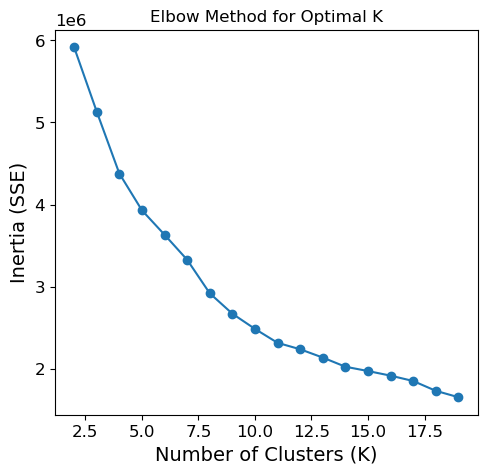

In [13]:
from sklearn.cluster import MiniBatchKMeans

inertia = []
K_range = range(2, 20)  # Limit to reasonable values

for k in K_range:
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=42, n_init=3)
    kmeans.fit(X_normal_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method for Optimal K")

As we can see from the elbow plot, there is not really a clear elbow point but there is a significant slowdown in inertia between k = 6 and k = 12 clusters.

# Silhouette Plot

To get a better sense of what k-value we want we create a silhouette plot. It measures the quality of clustering by calculating how similar each point is to its own cluster compared to other clusters. It assigns a silhouette score ranging from -1 to +1, where higher values indicate better-defined clusters. A silhouette plot visualizes these scores for each point in a cluster, helping to assess how well the clusters are separated and whether the clustering is meaningful.

Processing k=6...


c:\Users\hakon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\hakon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Processing k=8...


c:\Users\hakon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\hakon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Processing k=10...


c:\Users\hakon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\hakon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Processing k=12...


c:\Users\hakon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\hakon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


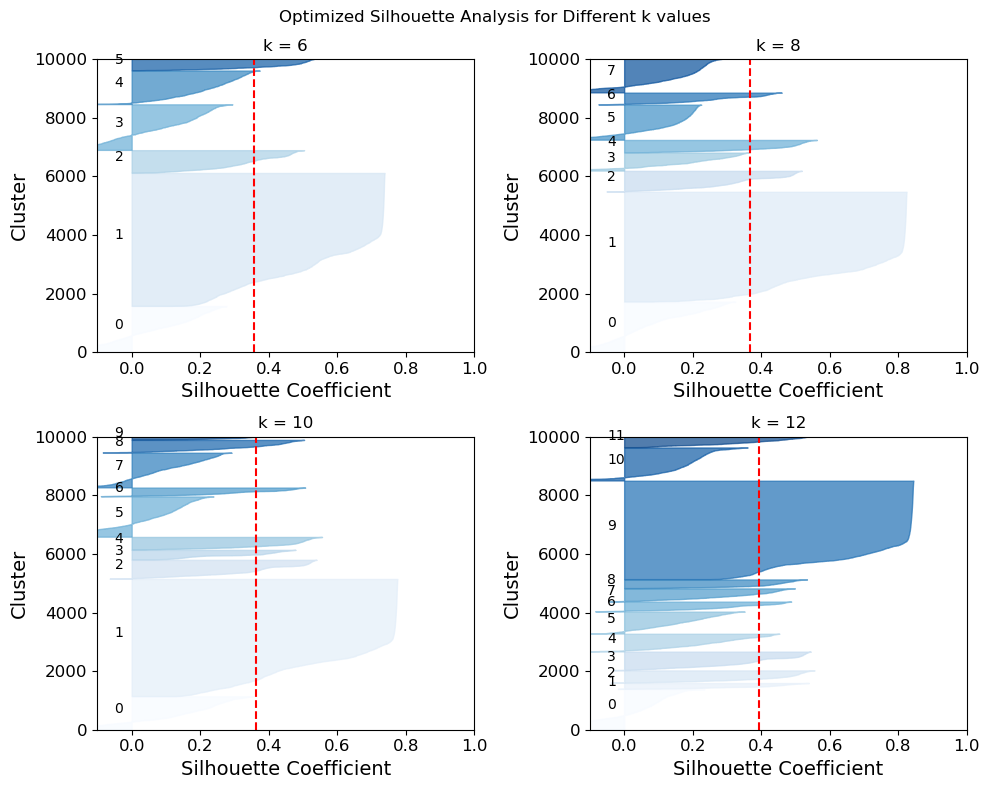

In [15]:
plot_silhouette(X_normal, scaler)

We can see from the silhouette analysis that the silhouette coefficients are not great but ``n_clusters = 10`` performs the best with most clusters crossing the dashed line representing the silhouette score.

# Train the Model

In [21]:
# Selected number of clusters
n_clusters = 10

# Train K-Means on normal dataset (done outside the function)
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=256, random_state=21)
kmeans.fit(X_normal_scaled)  # Assume X_normal_scaled is the scaled training data

MiniBatchKMeans(batch_size=256, n_clusters=10, random_state=21)

In [34]:
# Compute baseline inertia for normal data (for thresholding)
normal_labels = kmeans.predict(X_normal_scaled)
normal_inertia_per_cluster = np.zeros(kmeans.n_clusters)

for i in range(kmeans.n_clusters):
    cluster_points = X_normal_scaled[normal_labels == i]
    normal_inertia_per_cluster[i] = np.sum((cluster_points - kmeans.cluster_centers_[i])**2) / len(cluster_points)  # Normalize by points


# Anomaly Detection with K-Means Clustering

Now we want to use K-Means clustering to detect anomalies in our datasets. We first train the model on normal data, calculating the inertia (fit quality) for each cluster. Then, we compare test data by predicting its clusters and computing the anomaly inertia. This is visualized in bar plots, showing anomaly inertia for each cluster, with red lines representing normal inertia for comparison. This helps identify unusual data points. When the bar plots have inertia values far from the red lines it indicates anomalies.


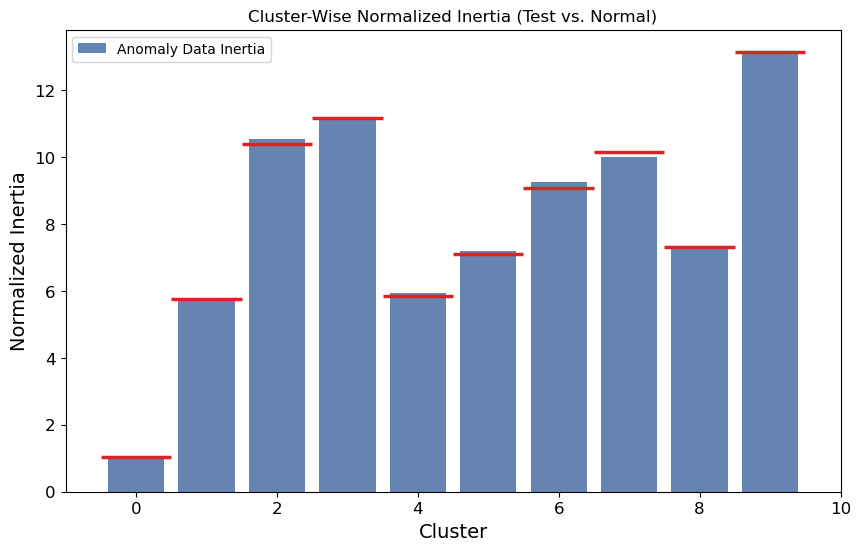

array([ 1.03870252,  5.8075039 , 10.56001728, 11.15529856,  5.93556264,
        7.20430806,  9.25684675, 10.0003808 ,  7.33672749, 13.15833567])

In [38]:
plot_kmeans_inertias(normal_inertia_per_cluster, kmeans, scaler, test_data, is_test_data=True)

The inertias form the test data allign well with the inertias form the training data.

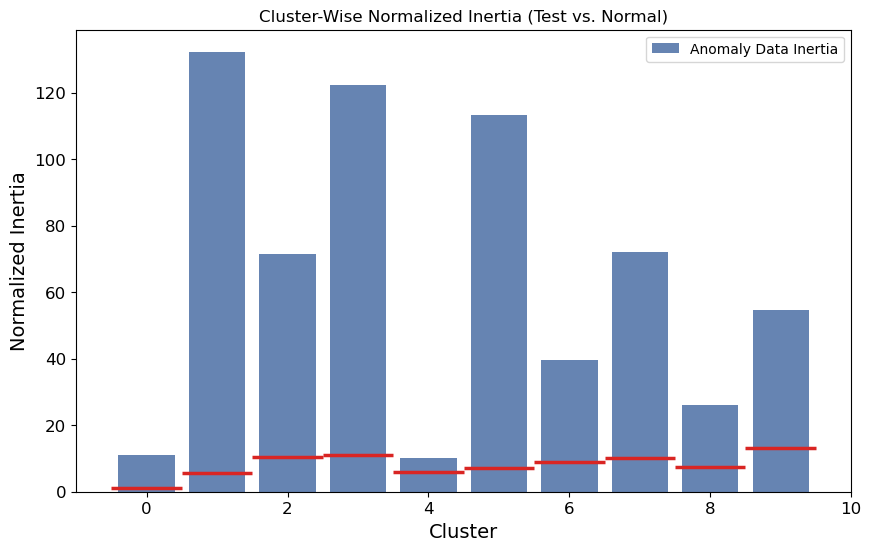

array([ 11.07984239, 132.29064388,  71.58722211, 122.20201615,
        10.08219597, 113.30475087,  39.50426989,  71.92687925,
        25.98753148,  54.55091732])

In [29]:
plot_kmeans_inertias(normal_inertia_per_cluster, kmeans, scaler, filename="IMU_earthquake.csv")

The inertias are far off from what was computed from normal data. This indicates a high amount of anomalies.

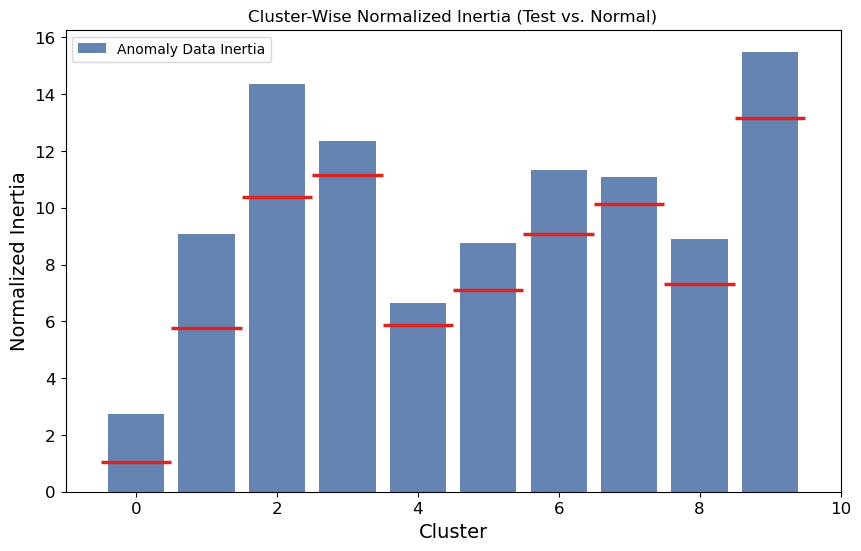

array([ 2.73427584,  9.06325928, 14.37521572, 12.34165541,  6.65453142,
        8.76710376, 11.3435174 , 11.07977116,  8.90707792, 15.49769044])

In [39]:
plot_kmeans_inertias(normal_inertia_per_cluster, kmeans, scaler, filename="IMU_20Hz_freq_drop.csv")

We know that ``IMU_20Hz_freq_drop.csv`` should only contain normal data, but their inertias are clearly higher. This is likely due to the setup of the IMU (see assumptions).
However, the increase in inertias per cluster is relatively small compared to the timeseries containing anomalies. 

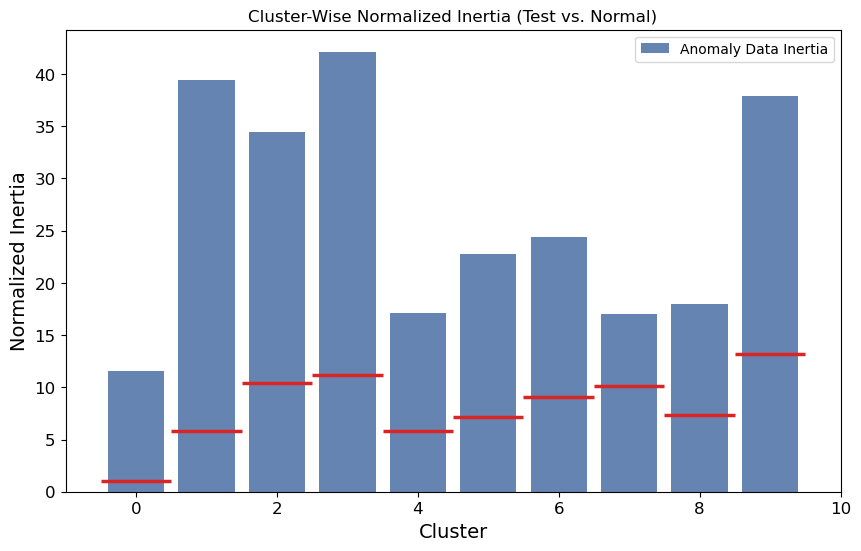

array([11.58378534, 39.42500157, 34.49559869, 42.13989957, 17.12842714,
       22.79329721, 24.37653189, 17.00363677, 18.01081255, 37.91532615])

In [32]:
plot_kmeans_inertias(normal_inertia_per_cluster, kmeans, scaler, filename="IMU_hitting_platform.csv")

Again, we see that the inertias are far off from normal, indicating lots of anomalies.

# Real-time data using K-means

Now that we have a way to detect anomalies using K-means, we can change the time window and time step to see if this can be used in online mode.

In [ ]:
# Define global variables
filename = "IMU_20Hz_freq_drop_2.csv"
X_data = None

def load_data():
    """Loads data from the selected file and updates slider limits."""
    global X_data, filename
    df = get_data_frame(filename)  # Load data using the selected filename
    df = add_time_column(df)
    df_resampled = resample_to_10Hz(df)
    X_data = extract_rolling_features(df_resampled)

    # Drop NaN values and update slider max values
    X_data = X_data.dropna().reset_index(drop=True)
    max_length = max(1, len(X_data))  

    time_slider.max = max_length - 1  
    window_slider.max = max_length  

# Create a dropdown for file selection
file_options = ["IMU_20Hz_freq_drop_2.csv", "IMU_10Hz.csv", "IMU_20Hz_freq_drop.csv", "IMU_extra_weigth.csv", "IMU_earthquake.csv", "IMU_hitting_arm.csv"]  # Add your available CSV files here
file_dropdown = widgets.Dropdown(
    options=file_options,
    value=file_options[0],  # Default to the first file
    description='Select File:'
)

def file_dropdown_callback(change):
    """Callback function to handle file change from the dropdown."""
    global filename
    filename = change['new']  # Get the new file name
    load_data()  # Reload the data with the new file
    interactive_plot.update()  # Update the plot with the new data

# Link dropdown to the callback
file_dropdown.observe(file_dropdown_callback, names='value')

# Create sliders
window_slider = widgets.IntSlider(
    value=100, min=1, max=100, step=1, description='Window size:'
)
time_slider = widgets.IntSlider(
    value=0, min=0, max=99, step=1, description='Time step:'
)

# Updated function to handle the new sliders without bbcolor
def print_update(window_size, time_step):
    df = get_data_frame(filename)
    df = add_time_column(df)
    df_resampled = resample_to_10Hz(df)
    X_data = extract_rolling_features(df_resampled)

    # Drop NaN values
    X_data = X_data.dropna().reset_index(drop=True)

    # Ensure xstart and xend are within bounds
    xstart = time_step
    xend = min(time_step + window_size, len(X_data) - 1)

    # Slice the data window
    X_data_window = X_data.iloc[xstart:xend]

    # Scale the data
    X_data_scaled = scaler.transform(X_data_window)

    # Predict cluster labels
    anomaly_labels = kmeans.predict(X_data_scaled)

    # Compute per-cluster normalized inertia
    anomaly_inertia_per_cluster = np.zeros(kmeans.n_clusters)
    for i in range(kmeans.n_clusters):
        cluster_points = X_data_scaled[anomaly_labels == i]
        if len(cluster_points) > 0:  # Avoid division by zero
            anomaly_inertia_per_cluster[i] = np.sum((cluster_points - kmeans.cluster_centers_[i])**2) / len(cluster_points)

    # Plot results
    clusters = np.arange(kmeans.n_clusters)

    bar_color = (0.0, 0.2, 0.50)  # Soft blue for bars
    line_color = sns.color_palette("Reds", as_cmap=True)(0.7)  # Soft red for lines

    plt.figure(figsize=(10, 6))
    plt.bar(clusters, anomaly_inertia_per_cluster, color=bar_color, alpha=0.6, label="Anomaly Data Inertia")

    bar_width = 0.6  # Adjust based on your bar width
    # Plot horizontal red lines for each cluster at its corresponding normal inertia value
    for i, normal_value in enumerate(normal_inertia_per_cluster):
        plt.hlines(y=normal_value, xmin=i - 0.5, xmax=i + 0.5, colors=line_color, linestyles="-", linewidth=2.5)

    plt.ylabel("Normalized Inertia")
    plt.title("Cluster-Wise Normalized Inertia (Test vs. Normal) - Rolling window")
    plt.legend()
    plt.show()

    return anomaly_inertia_per_cluster

# Link sliders to the function
interactive_plot = interactive(print_update, window_size=window_slider, time_step=time_slider)
output = interactive_plot.children[-1]
output.layout.height = '600px'

# Load data initially
load_data()

# Display dropdown, sliders, and plot
display(file_dropdown)
display(interactive_plot)

(NTOE to Andrei: output is not saved in the notebook. See attached images to see output, or run the script)

As expected, a larger window size increases the accuracy of the reading but given a window size of 1200 (meaning 120 seconds of readings, given 10Hz measurments), we can see fairly precise readings, meaning clear outliers for most of the data with anomalies. This is not truly real-time but can still give an early warning in a process that something is going wrong.

Further improvements of the implementation of the model would be to define a threshold, triggering an alarm when the inertias get too large. But now, lets explore another approach for anomaly detection.

# **Isolation Forest**

The Isolation Forest algorithm works by isolating instances in a dataset. The model builds decision trees called iTrees on the normal operation dataset and detects anomalies by isolating a new instance and calculating the average path length. Shorter path lengths are given a higher anomaly score, indicating that the instance is more likely to be an anomaly. This is because anomalies are isolated more quickly in the trees compared to normal instances, which require more splits to be fully separated.

There are a few hyperparameters that can be used to train and tune the model, but the most important and sensitive hyperparameter is contamination. Contamination decides how much of the training set is considered anomalies. This can be used to tune how aggressive the model is by comparing it to other datasets. Since we assumed that the training dataset was an ideel case with noise, we set the contamination parameter to be 1%.

## Training IsolationForrest

In [51]:
from sklearn.ensemble import IsolationForest

model_iso = IsolationForest(contamination=0.01, n_estimators=300, max_samples=1.0, random_state=42)
model_iso.fit(X_normal_scaled)

IsolationForest(contamination=0.01, max_samples=1.0, n_estimators=300,
                random_state=42)

# Testing
To measure the performance of the model, we calculate the anomaly fraction for all the datasets. Ideally, the anomaly fraction of the training set should match the contamination parameter, and for the other datasets, the anomaly fractions should reflect the respective scenarios. However, anomaly fraction alone is not enough to determine if the model is effectively detecting anomalies.

Therefore, we manually check when anomalies occur by selecting some sensor data. This approach is far from ideal, as we have a multidimensional feature set, and the main objective is to detect anomalies. For instance, if the robot arm is actively performing a task, we expect anomalies to be detected during this period. However, it's possible that the algorithm might detect anomalies at the wrong time, as it may not recognize the exact moment the robot arm starts. This limitation is inherent to the algorithm, and it may not catch anomalies in real-time as expected

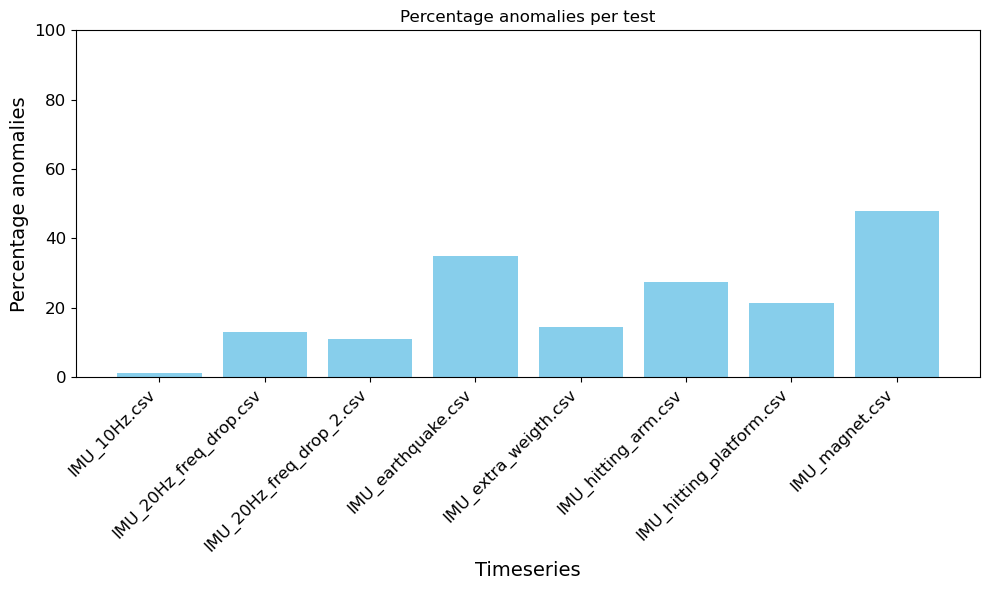

In [56]:
files = [
    "IMU_10Hz.csv", 
    "IMU_20Hz_freq_drop.csv", 
    "IMU_20Hz_freq_drop_2.csv", 
    "IMU_earthquake.csv", 
    "IMU_extra_weigth.csv", 
    "IMU_hitting_arm.csv", 
    "IMU_hitting_platform.csv", 
    "IMU_magnet.csv"
]

anomaly_fractions = []
res_df = []
for file in files:
    iso_df = iso_anomaly_detection(file, model_iso)
    anomaly_frac = anomaly_fraction(iso_df)
    res_df.append(iso_df)
    anomaly_fractions.append(anomaly_frac)

plot_anomaly_frac(files, anomaly_fractions)

The plot above indicates that the model is able to detect the real world simulated anomalies. We also see that it struggels to differenciate ``IMU_20Hz`` (which should contain normal data) with ``IMU_extra_weight``. This is a limitation of the model that needs to be taken into account.

The following plots contain sensordata of the same sequence of motion of the robotic arm. The difference between them is the scenarios. The plots lets us visually confirm if the model detects deviations from the normal IMU_10Hz timeseries at the right time. The datasets were synchronized using data from the other sensors and aligned accordingly.

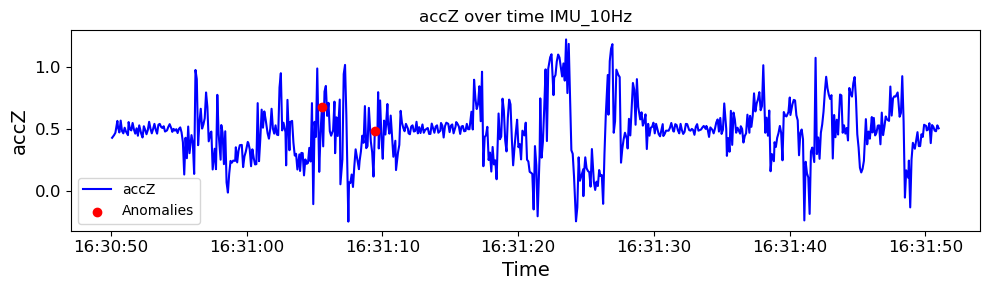

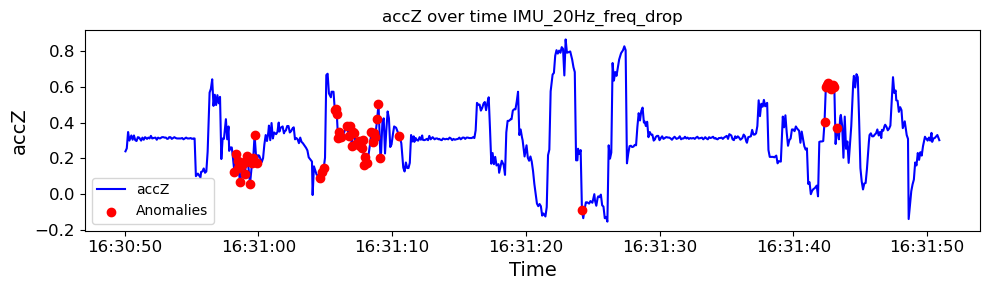

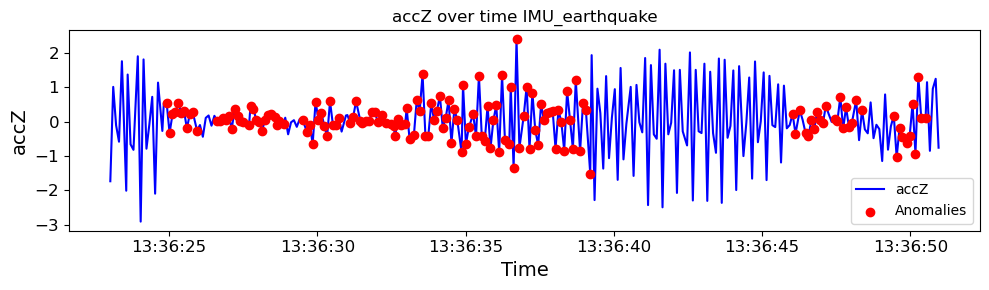

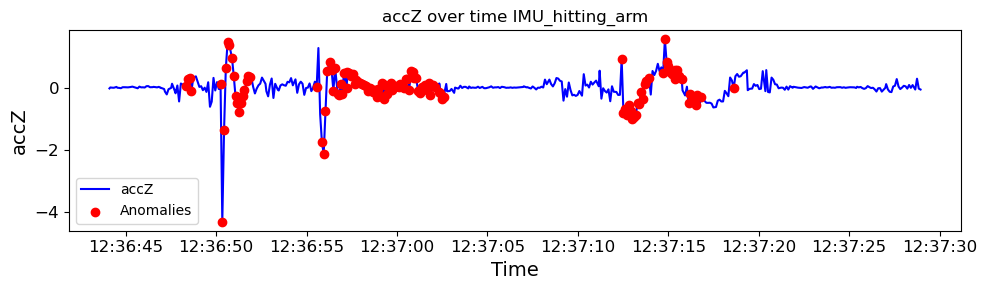

In [61]:
# sensor_columns = ["accX", "accY", "accZ", "gyroX", "gyroY", "gyroZ", "magX", "magY", "magZ"]
sensor_columns = ["accZ"]
plot_sensor_data_with_anomalies(res_df[0] , sensor_columns, start_time='16:30:50', end_time='16:31:50', name="IMU_10Hz")     # IMU_10Hz.csv 
plot_sensor_data_with_anomalies(res_df[2] , sensor_columns, start_time='16:30:50', end_time='16:31:50', name="IMU_20Hz_freq_drop")     # IMU_20Hz_freq_drop.csv
plot_sensor_data_with_anomalies(res_df[3] , sensor_columns, start_time='13:36:23', end_time='13:36:50', name="IMU_earthquake")     # IMU_earthquake.csv
plot_sensor_data_with_anomalies(res_df[5] , sensor_columns, start_time='12:36:44', end_time='12:37:28', name="IMU_hitting_arm")     # IMU_hitting_arm.csv

After examining the same sensor over different scenarios, it is clear that the model detects anomalies during deviations form the normal IMU_10Hz data. This is especially visible for ``accZ`` in the plots above.
After analyzing the occurrence and frequency of anomalies, we concluded that the model's performance was satisfactory.

# Real-time Isolation Forest 
To implement the Isolation Forest model in a real-time setting, a sliding window approach is used. This involves maintaining a fixed-size window of the most recent data points. As new data arrives, the window "slides" forward by one data point, dropping the oldest and adding the newest.

At each step, the model evaluates whether the data in the current window is anomalous. This decision is based on the features extracted from the window. The Isolation Forest model calculates an anomaly score for the windowed data and determines if the current data point is anomalous or not.

In [ ]:
detector = OnlineAnomalyDetector(model_iso, scaler, window_size=10)

result_df = stream_data("IMU_10Hz.csv", detector, delay=0.00, doPrint=False, max_length=10000)


🔍 Starter online anomaly detection...


🔎 Totalt: 9991 datapunkter.
🚨 Anomalier: 301 (3.01%)
✅ Normale datapunkter: 9690 (96.99%)


# **Gaussian Mixture**

A Gaussian Mixture Model (GMM) is a probabilistic model that represents data as a combination of multiple Gaussian distributions. This makes it an ideal choice for anomaly detection.

Each data point is assigned a probability of belonging to different clusters, making GMM more flexible than k-means for capturing complex data distributions.

### Finding the Number of Clusters for Gaussian Mixture
We analyse the BIC and AIC scores to determine the number of components (clusters) for GMM. AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) are measures of model quality that balance goodness of fit and model complexity.

* AIC favors models that fit the data well but penalizes complexity less strictly.
* BIC applies a stronger penalty for complexity, often leading to simpler models.

Lower AIC/BIC values indicate a better model, but too many clusters in GMM (Gaussian Mixture Model) can lead to overfitting.

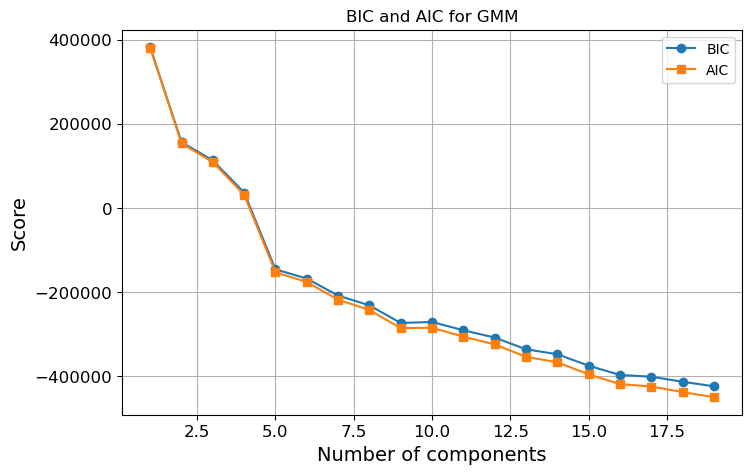

In [47]:
# Check for a range of n_components
n_components_range = range(1, 20)

plot_bic_aic(X_normal_scaled, n_components_range)

As mentioned, too many clusters may cause the model to overfit on noise, as well as making the model compytationally expensive. For anomaly detection in our case, chosing ``n_components`` around the elbow point is sufficient. We identify the elbow point at 5, but we found that ``n_components = 6`` works better in our case.

# Training Gaussian Mixture

In [48]:
from sklearn.mixture import GaussianMixture

# Tune number of components
n_components = 6

# Train the model on normal data
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=21)
gmm.fit(X_normal_scaled)

GaussianMixture(n_components=6, random_state=21)

### Define a Threshold
We define a threshold to indicate how unlikely new data results are. Based on the training data, we chose a small percentile of 0.5%. This means that if the mean likelihood falls below this threshold, we can theoretically be 99.5% confident that the robot arm is not operating as expected. This is most definatley not true in our case, since the IMU is unlikely to be mounted concistantly (see assumptions). We instead use the threshold as an indication.

In [49]:
# Calculate threshold based on training data
log_likelihood_train = gmm.score_samples(X_normal_scaled)
threshold = np.percentile(log_likelihood_train, 0.5)

# Testing
Lets first validate our model on the whole timeseries that the model is partially trained on.

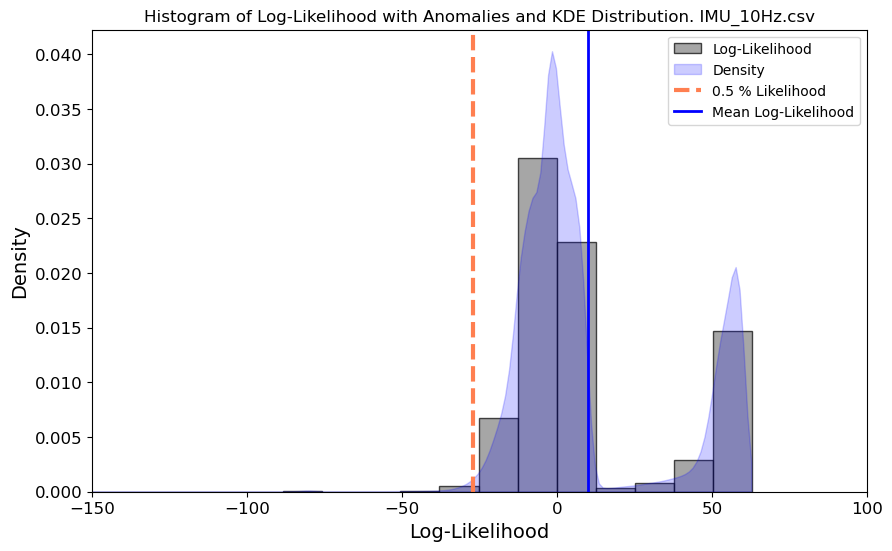

In [17]:
plot_anomalies_histogram("IMU_10Hz.csv", threshold, gmm, scaler, x_start=-150, x_end=100)

As expected, we get a mean log-likelihood of approxemately 10. Now, lets test on some of timeseries containing anomalies.

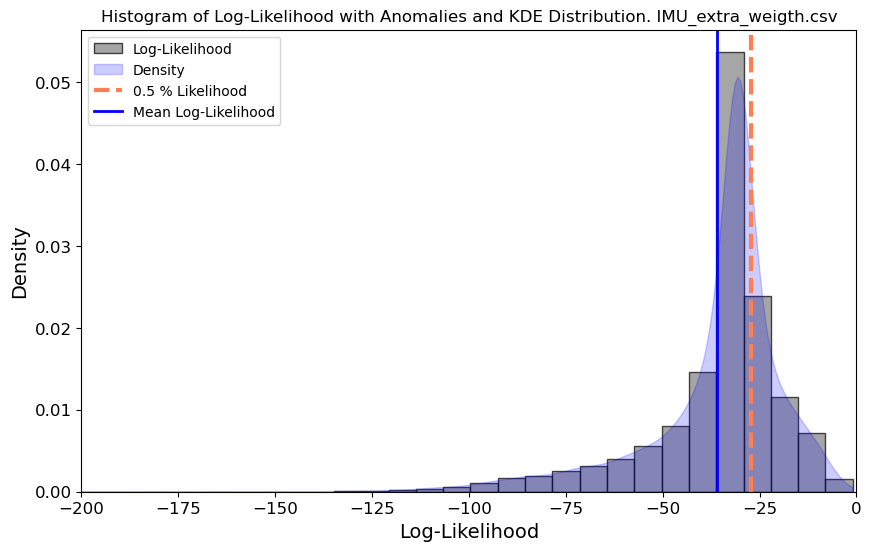

In [18]:
plot_anomalies_histogram("IMU_extra_weigth.csv", threshold, gmm, scaler, x_start=-200, x_end=0)

For ``IMU_extra_weigth.csv`` we see that the mean of the log-likelihood lies well below the 0.5% likelihood threshold. We can therfore confidently conclude from the timeseries that the robot arm contains faults and need attention. The same can be said about the timeseries below.

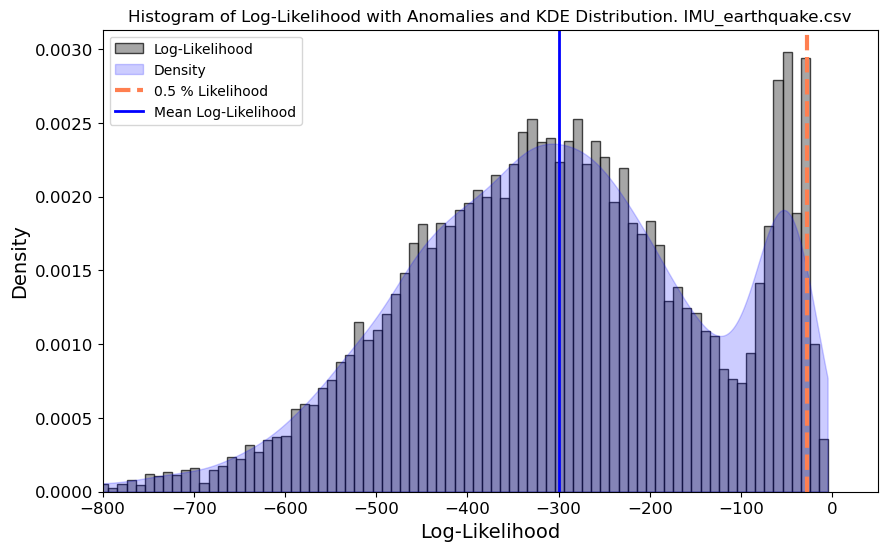

In [19]:
plot_anomalies_histogram("IMU_earthquake.csv", threshold, gmm, scaler, x_start=-800)

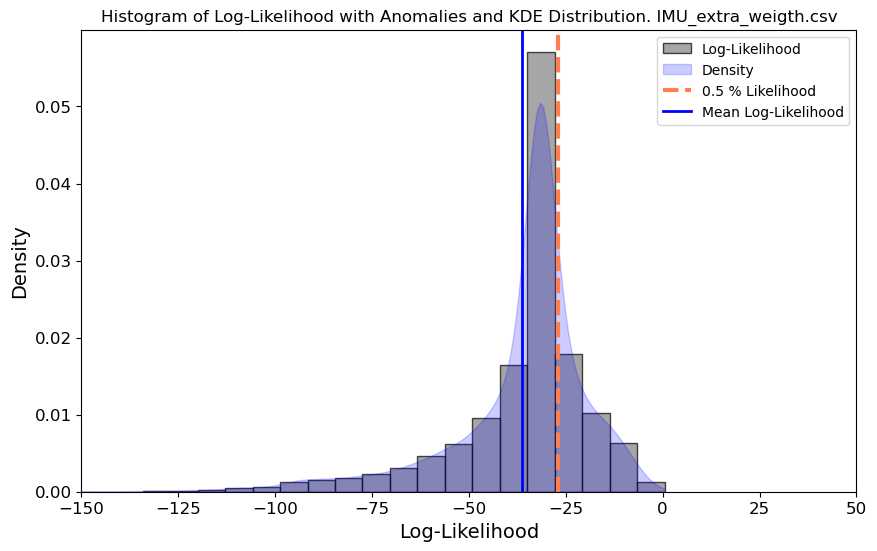

In [ ]:
plot_anomalies_histogram("IMU_extra_weigth.csv", threshold, gmm, scaler, x_start=-150)

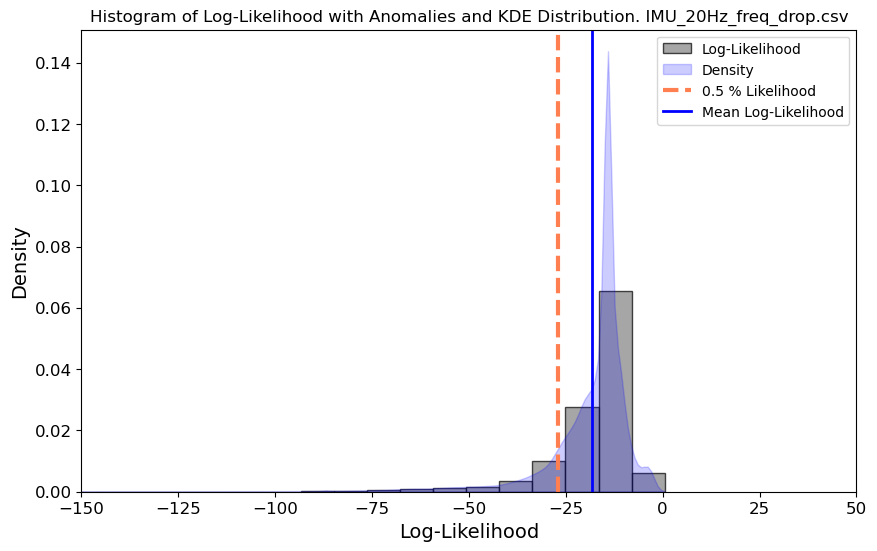

In [20]:
plot_anomalies_histogram("IMU_20Hz_freq_drop.csv", threshold, gmm, scaler, x_start=-150, x_end=50)

We know that ``IMU_20Hz_freq_drop.csv`` should only contain normal data, but it still has its mean log-likelihood well below zero. This is likely due to the setup of the IMU (see assumptions).

We still see that the mean log-likelihood is well above the threshold, which is good.

## Simulation of real-time data using GMM

To detect unusual behavior, we cannot rely on a single data point. Instead, we must analyze data over a time window. This approach helps account for random spikes, which are common and often caused by sensor noise rather than actual anomalies.

The function below calculates the mean log-likelihood within the current time window, providing a more robust indicator of anomalies. Additionally, the window is interactive, allowing for dynamic adjustments to better observe trends and detect deviations. By adjusting the "Start" slider, the system simulates how real-time data could be collected and used to trigger an alarm if an anomaly is detected (blue line below orange means something is wrong).

In [ ]:
plot_log_likelihood_timeseries("IMU_extra_weigth.csv", threshold, gmm, scaler)

(NTOE to Andrei: output is not saved in the notebook. See attached images to see output, or run the script)

# Conclusion and Next steps for futher improvements

We have explored three different models for anomaly detection, but we haven't yet developed a metric to objectively compare their performance. Since we currently don't have detailed labeled data, it's difficult to evaluate them properly. This will be the next step in our development.
Further improvements could be combining multiple models to create a more reliable anomaly detection system. This could make the predictions stronger by using the best features of each model.

Currently, the **Gaussian Mixture Model** appears to be the best option due to its probabilistic approach, which provides the likelihood of the current time series. This method is both effective and intuitive, making it well suited for implementation in a real time monitoring system. Compared to **K-Means**, which assumes circular clusters, the Gaussian Mixture Model (GMM) offers a better fit for the data by utilizing a directional covariance matrix. The scatter matrix reveals that the data is far from circular, indicating that the inertia metric used in k-means is not optimal for this distribution. GMM, with its ability to model elliptical clusters, is better suited to capture the underlying structure of the data. 

From the resulting plots we also see that the **Gaussian Mixture** model outperforms **Isolation Forrest**, especially for how it correcly separates ``IMU_20Hz`` (normal data) from ``IMU_extra_weigth`` (containing anomalies). The probability-based architecture of GMM makes it the ideal choice for our case.